In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('ggplot')

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import r2_score
from rfpimp import permutation_importances


In [4]:
df_courses = pd.read_csv('data/courses_2.csv', index_col =0)

In [5]:
df_assessments = pd.read_csv('data/assessments.csv', index_col =0)

In [6]:
df_vle = pd.read_csv('data/vle.csv', index_col =0)

In [7]:
df_studentInfo = pd.read_csv('data/studentInfo_2.csv', index_col =0)

In [8]:
df_studentRegistration = pd.read_csv('data/studentRegistration.csv', index_col =0)

In [9]:
df_studentAssessment = pd.read_csv('data/studentAssessment.csv', index_col =0)

In [10]:
df_studentVle_vle = pd.read_csv('data/studentVle_by_vle.csv', index_col =0)

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [11]:
df_studentVle_day = pd.read_csv('data/studentVle_by_day.csv', index_col =0)

## Summary of Findings from Exploration


### Courses
* 7 Total Modules
* data covers 4 "semesters" - Feb 2013, Oct 2013, Feb 2014, Oct 2014
* Each Module has 2-4 presentations, all of varying presentation length, but avg is 255 days (8.5mos)
* Modules - BBB, DDD, and FFF were offered each semester.
* Modules - AAA, CCC were offered in only 2 semesters
* Modules -- EEE, GGG were offered in 3 semesters
* Reason they list CCC, EEE, and GGG modules is due to them being "uneven" offered in 3 out of 4 semesters, or in CC's case, offerred in consecutive semesters, rather than in same one every yr like AAA.

### Assessments
* All Presentations have the same amount of Assessments every semester EXCEPT for BBB - 2014J (half the amount of assessments due to removing CMA assessments) and DDD - 2013B (double the amount of assessments due to having CMA assessments). 
* Weights always equal 200 for all presentations except for GGG (weight = 100. only its final exam carries any wieght and for CCC which has two final exams (weight =300)
* Dates tell you at what pt in presentation was the assessment held. Could add feature of % of class completed/progress....


### VLE
* There are 20 unique types of VLE. Some appear much more frequently than others
* Week_from and Week_to are only filled in around 1/6th of time - mainly for url, oucontent, page, questionnarie, resource, and subpage
* Each presentation has a different amount of VLE and it fluctuates from 100 - 500+


### StudentInfo
* Most students in dataset only took 1 Module-Presentation(84%)
* 11% of students took 2
* Most taken Module-Presentations were CCC-2014J and FFF-2014J (7%+ each). 
* Least taken Module-Presentations were AAA-2013J and AAA-2014J (<1.2% each)

###### Target Var - Final Result
* Final Result - 37% Pass, 31% Withdraw, 21% Fail, 9% Distinction
* If I change Final_Result to Pass = Pass+Distinction and Fail = Fail+Withdrawn, then Id have close to a balanced class

######  Demographic var frequency
* 8 Demographic Vars given
* Gender: 54% M, 46% F
* Region: Scotland and East Anglian region (10%+ each), London Region (9.8%). Least is Ireland (3.6%)
* Highest Education: A Level or Equivalent - 43%. Lower than A level - 40%. HE Qualification - 14%
* (https://www.quora.com/What-is-the-American-equivalent-of-A-Level)
* (https://universitycompare.com/advice/student/what-is-a-certificate-of-higher-education/)
* IMD Band: Lowest bands are the highest (10% each), but all are close) 
* Age Band: 70% in 0-35, 28% in 35-55
* Num of Previous Attempts: 0 == 87%
* Studied credits: 60 credits is the most frequent - 51%. 120 credits is 20%, 30 credits is 11, and 90 is 9%
* Disability: 90% No

######  Demographic vars vs. Final Result
* Relationship b/w Demographic vars and Final Result
* Men have slightly higher Pass/Distinction rate than Females (25 vs. 21%)
* Pass/Fail rates do vary a bit by region - largest discrepancy is in London: 5.6% fail vs. 4.1% pass
* More education qualification --> higher pass rate
* higher Imd bands --> higher pass rate
* lower pass rates if you've taken the course before.
* lower pass rates for those with disability
* Higher pass rates for smaller credit courses

### StudentRegistration
* 70% of time, Students stay registered. 30% they unregister
* 60 days before course starts is avg/median time students tend to register
* Median is 27 days for unregistration to take place from start date. Avg is 50.



### StudentAssessment

* Some Assessments have a very small std deviation in submission times, while others have a wide range (80 days)
* Submissions usually occur 116 days after course starts
* 5% of assessments are failed (<= 40 score)
* Avg assessment score is 75, median is 80
* Only 1 % of assessments are banked (carried over)



### StudentVle

* Created two dfs (df_studentVle_by_day) and (df_studentVle_by_vle) to show aggregated clicks by VLE by student and also by Day by VLE by Student
* avg clicks per VLE is 20, median is 3. Lots of outliers due to max value being close to 9k
* avg clicks per VLE per Day is 4, median is 2. Lots of outliers due to max being just under 7k


### Create Dataframe needed for first model iteration


In [ ]:
len(df_studentInfo)

In [ ]:
df_studentInfo.shape

In [ ]:
df_studentInfo.head()

In [ ]:
df_courses.head()

In [ ]:
courses = df_courses.add_prefix('courses_')

In [ ]:
result = pd.merge(df_studentInfo, courses, how='left', left_on=['code_module', 'code_presentation'], right_on=['courses_code_module', 'courses_code_presentation'])

In [ ]:
result = result.drop(['courses_code_module', 'courses_code_presentation'], axis = 1)

In [ ]:
result.shape

In [ ]:
df_assessments.head()

In [ ]:
df_assessments['assessment_type'].unique()

In [ ]:
num_assessments = df_assessments.groupby(['code_module','code_presentation']).count()['id_assessment'].reset_index().rename(columns={'id_assessment':'num_assessments'})

In [ ]:
mask_tma = df_assessments['assessment_type'] == 'TMA'
mask_cma = df_assessments['assessment_type'] == 'CMA'
mask_exam = df_assessments['assessment_type'] == 'Exam'

In [ ]:
num_tma_assessments = df_assessments[mask_tma].groupby(['code_module','code_presentation']).count()['id_assessment'].reset_index().rename(columns={'id_assessment':'num_tma_assessments'}).fillna(0)
num_cma_assessments = df_assessments[mask_cma].groupby(['code_module','code_presentation']).count()['id_assessment'].reset_index().rename(columns={'id_assessment':'num_cma_assessments'}).fillna(0)
num_exam_assessments = df_assessments[mask_exam].groupby(['code_module','code_presentation']).count()['id_assessment'].reset_index().rename(columns={'id_assessment':'num_exam_assessments'}).fillna(0)


In [ ]:
result = pd.merge(result, num_assessments, how='left', on=['code_module', 'code_presentation'])
result = pd.merge(result, num_tma_assessments, how='left', on=['code_module', 'code_presentation'])
result = pd.merge(result, num_cma_assessments, how='left', on=['code_module', 'code_presentation'])
result = pd.merge(result, num_exam_assessments, how='left', on=['code_module', 'code_presentation'])


#can also add some var regarding the timing of the assessments - i.e. total before halfway, total after halfway, etc.

In [ ]:
result.shape

In [ ]:
result = result.fillna(0)

In [ ]:
result.num_cma_assessments = result.num_cma_assessments.astype('int64')

In [ ]:
result.shape

In [ ]:
vle = df_vle.groupby(['code_module','code_presentation','activity_type']).size().reset_index().rename(columns={0:'num_vle'})



In [ ]:
vle_totals = vle.pivot_table(values = 'num_vle', index = ['code_module','code_presentation'], columns = 'activity_type')



In [ ]:
vle_totals['total_num_vle'] = vle_totals.sum(axis=1)

In [ ]:
vle_totals = vle_totals.reset_index().fillna(0)

In [ ]:
vle_totals = vle_totals.add_prefix('vle_')

In [ ]:
vle_totals.head()

In [ ]:
result = pd.merge(result, vle_totals, how='left', left_on=['code_module', 'code_presentation'],right_on=['vle_code_module', 'vle_code_presentation'])

In [ ]:
result.head()

In [ ]:
result = result.drop(['vle_code_module', 'vle_code_presentation'], axis = 1)

In [ ]:
result.shape

In [ ]:
result.columns


In [ ]:
len(result)

In [ ]:
df_studentRegistration.head()

In [ ]:
result = pd.merge(result, df_studentRegistration, how='left', on=['code_module', 'code_presentation','id_student'])

In [ ]:
result.shape

In [ ]:
df_studentAssessment.head() #won't add for now due to potential leakage

In [ ]:
df_studentVle_vle

In [ ]:
df_vle

In [ ]:
vle_actions = pd.merge(df_studentVle_vle, df_vle, how='left', on=['id_site', 'code_module','code_presentation'])

In [ ]:
vle_actions

In [ ]:
student_vle_agg_by_type = vle_actions.groupby(['id_student','code_presentation','code_module','activity_type']).sum()['sum_click']

In [ ]:
student_vle_agg_by_type = student_vle_agg_by_type.reset_index()

In [ ]:
student_vle_agg_by_type.head()

In [ ]:
student_vle_agg = student_vle_agg_by_type.pivot_table(values = 'sum_click', index = ['id_student','code_presentation','code_module'], columns = 'activity_type')


In [ ]:
student_vle_agg.head()

In [ ]:
student_vle_agg['total_num_vle_actions'] = student_vle_agg.sum(axis=1)

In [ ]:
student_vle_agg['total_num_vle_actions'].sum()

In [ ]:
df_studentVle_vle.sum_click.sum()

In [ ]:
student_vle_agg.head()

In [ ]:
student_vle_agg = student_vle_agg.reset_index()

In [ ]:
student_vle_agg = student_vle_agg.fillna(0)

In [ ]:
student_vle_agg['total_num_vle_actions'].sum()

In [ ]:
student_vle_agg.head()

In [ ]:
student_vle_agg = student_vle_agg.add_prefix('click_')

In [ ]:
student_vle_agg.head()

In [ ]:
result = pd.merge(result, student_vle_agg, how='left', left_on=['code_module', 'code_presentation','id_student'],right_on=['click_code_module', 'click_code_presentation','click_id_student'])

In [ ]:
result.head()

In [ ]:
result.columns

In [ ]:
result = result.drop(['click_id_student','click_code_presentation', 'click_code_module'],axis =1)

In [ ]:
result.shape

In [ ]:
result.head()

In [ ]:
result.info()

In [ ]:
result.describe()

In [ ]:
import seaborn as sns

In [ ]:
plt.hist(result.final_result_edit)

In [ ]:
result.columns

In [ ]:
result.to_csv('data/presentation_outcomes_dataset_for_modeling.csv')

In [12]:
result = pd.read_csv('data/presentation_outcomes_dataset_for_modeling.csv',index_col =0)

In [ ]:
result.head()

In [ ]:
result.groupby('id_student').size().sort_values(ascending = False)

### Modeling

In [ ]:
'''
#columns to get dummies
['gender', 'region','highest_education', 'imd_band', 'age_band','studied_credits', 'disability', 'module_presentation','final_result_edit']

#columns to drop
['final_result', 'code_module', 'code_presentation', 'id_student', 'courses_date_time']
'''

In [13]:
df = result.drop(['final_result', 'code_module', 'code_presentation', 'id_student', 'courses_date_time'], axis = 1)

In [14]:
df = pd.get_dummies(df)

In [15]:
df.head()

,num_of_prev_attempts,studied_credits,courses_module_presentation_length,num_assessments,num_tma_assessments,num_cma_assessments,num_exam_assessments,vle_dataplus,vle_dualpane,vle_externalquiz,...,module_presentation_EEE-2014J,module_presentation_FFF-2013B,module_presentation_FFF-2013J,module_presentation_FFF-2014B,module_presentation_FFF-2014J,module_presentation_GGG-2013J,module_presentation_GGG-2014B,module_presentation_GGG-2014J,final_result_edit_Fail,final_result_edit_Pass
0,0,240,268,6,5,0,1,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,60,268,6,5,0,1,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,60,268,6,5,0,1,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0,60,268,6,5,0,1,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,60,268,6,5,0,1,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
lst = df.columns

In [17]:
df = df.drop(['final_result_edit_Pass'],axis = 1)

In [18]:
df = df.drop(['date_unregistration'],axis = 1)

In [19]:
y = df.pop('final_result_edit_Fail')

In [20]:
X = df

### Functions to test Classification Models

In [21]:
def get_scores(classifier, X_train, X_test, y_train, y_test, color = 'navy', **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    y_predict_train = model.predict(X_train)
    y_probas = model.predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_probas[:,1]) #take probas of positive class
    
    train_acc = accuracy_score(y_train, y_predict_train)
    test_acc = accuracy_score(y_test, y_predict)
    pre = precision_score(y_test, y_predict)
    re = recall_score(y_test, y_predict)
   
    roc_auc = auc(fpr, tpr)
    
    model_name = type(model).__name__
    
    lw = 2
    plt.plot(fpr, tpr, color=color,
             lw=lw, label='{0} - AUC = {1:0.2f}'.format(model_name, roc_auc)
            )
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC')
    plt.legend(loc="lower right")
    plt.show()
    
     
    if model_name == 'RandomForestClassifier':
        oob = model.oob_score_
        return 'Train Accuracy: {0:0.2f}. Test Accuracy: {1:0.2f}. OOB: {2:0.2f}. Precision: {3:0.2f}. Recall: {4:0.2f}. AUC: {5:0.2f}'.format(train_acc, test_acc, oob, pre, re, roc_auc)    
    
    else:
        return 'Train Accuracy: {0:0.2f}. Test Accuracy: {1:0.2f}. Precision: {2:0.2f}. Recall: {3:0.2f}. AUC: {4:0.2f}'.format(train_acc, test_acc, pre, re, roc_auc)
           


In [22]:
def feature_importance(classifier, X_train, X_test, y_train, y_test, color ='red', **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    cols = []
    values = []
    for f in range(25):

        idx = indices[f]
        col = X_train.columns[idx]
        value = importances[idx]
        cols.append(col)
        values.append(value)
   
    model_name = type(model).__name__

    fig, ax = plt.subplots()
    y_pos = np.arange(len(cols))
    ax.barh(y_pos, values,
            color=color, align="center")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(cols)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Feature Importance')
    ax.set_title('{0} - Top 25 features'.format(model_name))

    plt.show()

### Train Test Split - use aggressive amount for Test since sample size is >30k

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.25, random_state = 42)

In [24]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [25]:
initial_trees = int(np.sqrt(len(X_train.columns)))

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


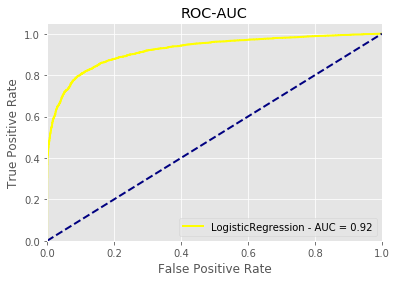

'Train Accuracy: 0.86. Test Accuracy: 0.85. Precision: 0.84. Recall: 0.87. AUC: 0.92'

In [26]:
get_scores(LogisticRegression, X_train, X_test, y_train, y_test, color = 'yellow', random_state = 42)

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


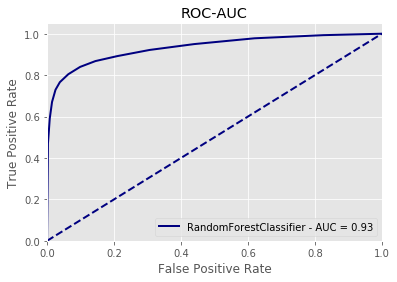

'Train Accuracy: 1.00. Test Accuracy: 0.87. OOB: 0.85. Precision: 0.90. Recall: 0.84. AUC: 0.93'

In [27]:
get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test, color = 'navy', n_estimators = initial_trees, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

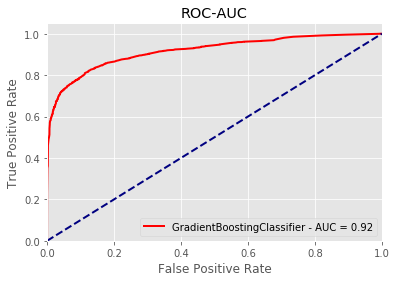

'Train Accuracy: 0.85. Test Accuracy: 0.84. Precision: 0.91. Recall: 0.77. AUC: 0.92'

In [28]:
get_scores(GradientBoostingClassifier, X_train, X_test, y_train, y_test, color = 'red', n_estimators = initial_trees, learning_rate = 0.1, random_state = 42)

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


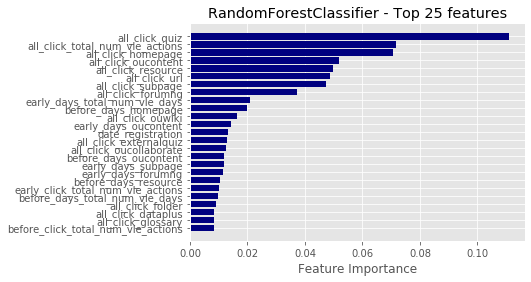

In [29]:
feature_importance(RandomForestClassifier, X_train, X_test, y_train, y_test, color = 'navy', n_estimators = initial_trees, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

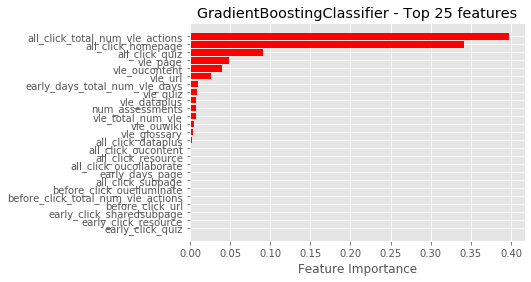

In [30]:
feature_importance(GradientBoostingClassifier, X_train, X_test, y_train, y_test, n_estimators = initial_trees, learning_rate = 0.1, random_state = 42)

### Looks to be some Leakage due to Click Info

In [36]:
click_cols = ['all_click_dataplus',
'all_click_dualpane',
'all_click_externalquiz',
'all_click_folder',
'all_click_forumng',
'all_click_glossary',
'all_click_homepage',
'all_click_htmlactivity',
'all_click_oucollaborate',
'all_click_oucontent',
'all_click_ouelluminate',
'all_click_ouwiki',
'all_click_page',
'all_click_questionnaire',
'all_click_quiz',
'all_click_repeatactivity',
'all_click_resource',
'all_click_sharedsubpage',
'all_click_subpage',
'all_click_url',
'all_click_total_num_vle_actions']

In [37]:
X_train_v2 = X_train.drop(click_cols,axis = 1)
X_test_v2 = X_test.drop(click_cols,axis = 1)

In [38]:
initial_trees_2 = int(np.sqrt(len(X_train_v2.columns)))

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


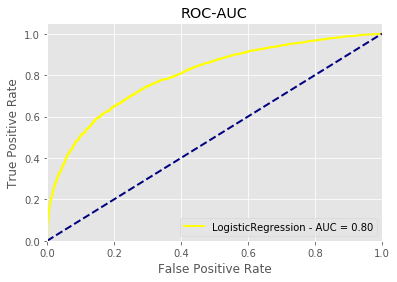

'Train Accuracy: 0.72. Test Accuracy: 0.72. Precision: 0.72. Recall: 0.77. AUC: 0.80'

In [39]:
get_scores(LogisticRegression, X_train_v2, X_test_v2, y_train, y_test, color = 'yellow')

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


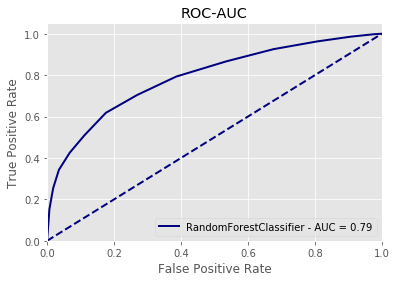

'Train Accuracy: 0.99. Test Accuracy: 0.72. OOB: 0.68. Precision: 0.75. Recall: 0.70. AUC: 0.79'

In [40]:
get_scores(RandomForestClassifier, X_train_v2, X_test_v2, y_train, y_test, color = 'navy', n_estimators = initial_trees, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

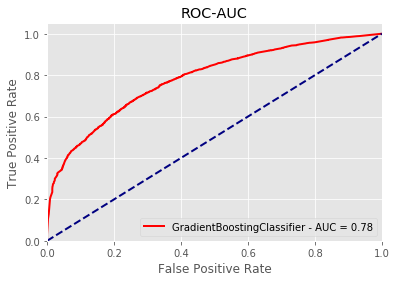

'Train Accuracy: 0.71. Test Accuracy: 0.71. Precision: 0.75. Recall: 0.67. AUC: 0.78'

In [41]:
get_scores(GradientBoostingClassifier, X_train_v2, X_test_v2, y_train, y_test, color = 'red', n_estimators = initial_trees, learning_rate = 0.1, random_state = 42)

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


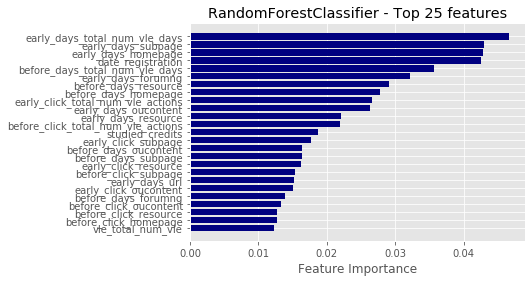

In [42]:
feature_importance(RandomForestClassifier, X_train_v2, X_test_v2, y_train, y_test, color = 'navy', n_estimators = initial_trees, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

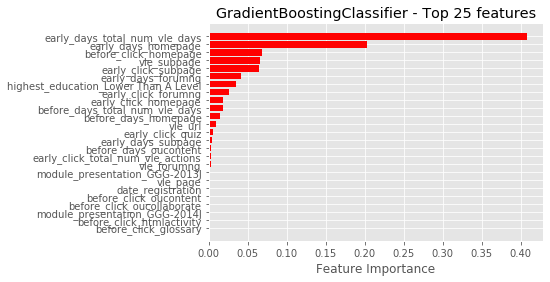

In [43]:
feature_importance(GradientBoostingClassifier, X_train_v2, X_test_v2, y_train, y_test, color = 'red', n_estimators = initial_trees, learning_rate = 0.1, random_state = 42)

### Want to revisit EDA to see what baseline predictions I could come up with to compare to models which don't use click data

In [44]:
result.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,before_days_ouelluminate,before_days_ouwiki,before_days_page,before_days_questionnaire,before_days_quiz,before_days_resource,before_days_sharedsubpage,before_days_subpage,before_days_url,before_days_total_num_vle_days
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,9.0,5.0,44.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,1.0,29.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,6.0,3.0,33.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,0.0,0.0,0.0,0.0,0.0,7.0,0.0,10.0,2.0,58.0


In [45]:
df_eda = result.drop(['final_result', 'code_presentation', 'id_student', 'courses_date_time'], axis = 1)

In [46]:
df_eda.columns

Index(['code_module', 'gender', 'region', 'highest_education', 'imd_band',
       'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability',
       'module_presentation',
       ...
       'before_days_ouelluminate', 'before_days_ouwiki', 'before_days_page',
       'before_days_questionnaire', 'before_days_quiz', 'before_days_resource',
       'before_days_sharedsubpage', 'before_days_subpage', 'before_days_url',
       'before_days_total_num_vle_days'],
      dtype='object', length=136)

In [47]:
cols = ['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'code_module']

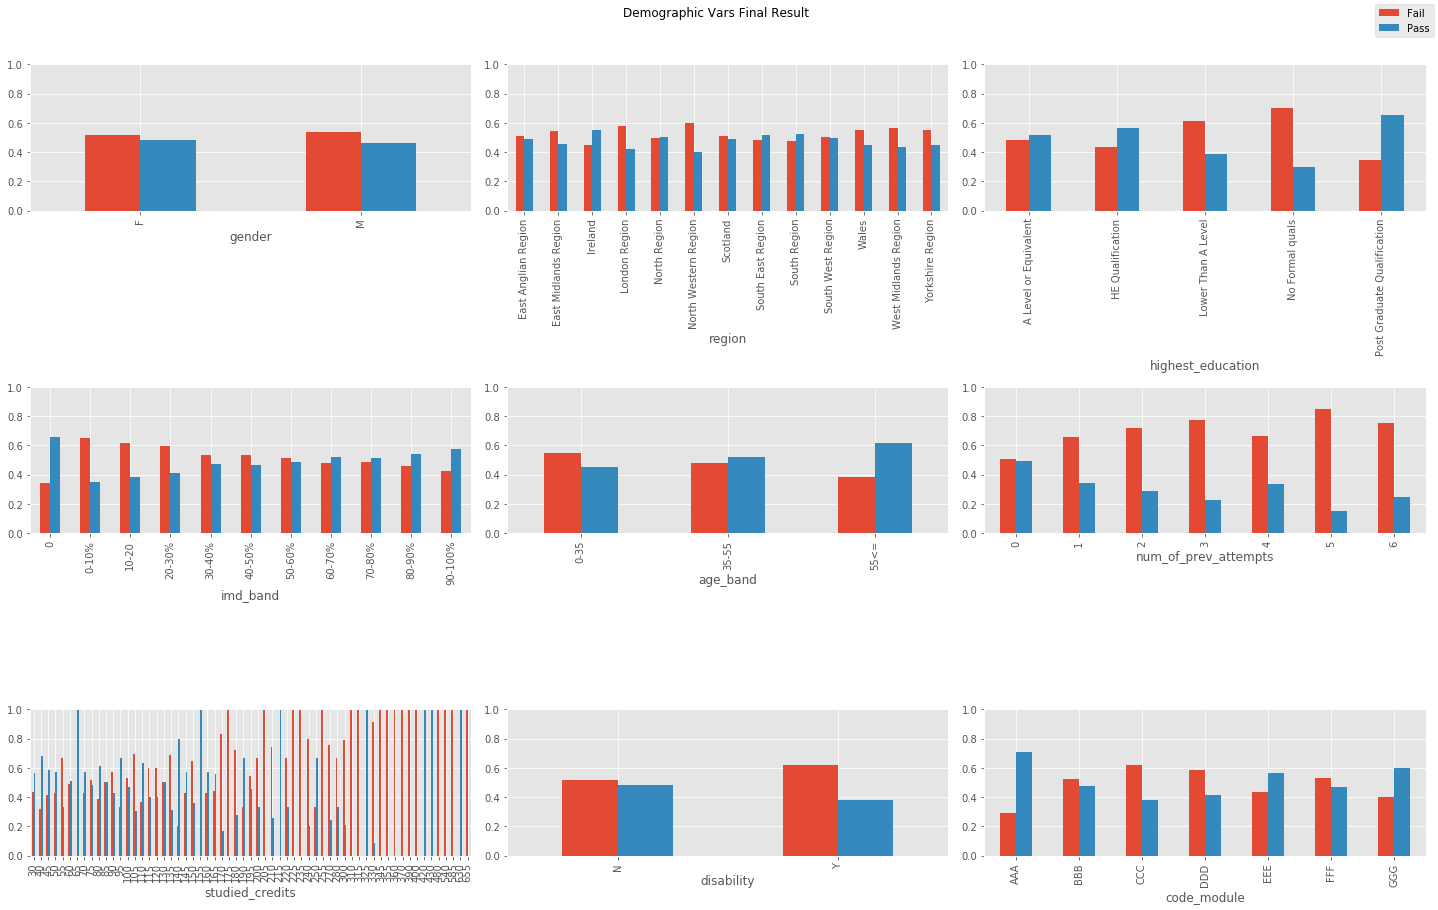

In [48]:
fig, axs = plt.subplots(3,3, figsize = (20,12))
fig.suptitle('Demographic Vars Final Result', x = 0.5, y = 1.05)

for i, ax in enumerate(axs.flatten()):
                       
    cross_t = pd.crosstab(df_eda[cols[i]], df_eda['final_result_edit'], rownames=[cols[i]])
    cross_t.apply(lambda r: r/r.sum(), axis=1).plot(kind="bar", ax=ax)
    ax.set_ylim(0,1)
    ax.get_legend().remove()

handles, labels = ax.get_legend_handles_labels()   
fig.legend(handles, labels, loc='upper right')
plt.tight_layout();



* Gender/Disability: All Fail
* Code Module: AAA, EEE, GGG: Pass
* Age Band: 0-35 fail, all others" pass
* IMD Band - at and above 60-70%: pass
* Ireland, North Region, South East Region, South Region: Pass
* HE Qualification, A Level or Equivalent, Post Graduate Qual: Pass

* Gender & Disability

In [134]:
np.sum(y_test)

4299

In [133]:
len(y_test)

8149

In [141]:
# Gender and Disability --> predicting all fail
y_predict = np.ones(len(y_test))

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re


(0.5275493925635047, 0.5275493925635047, 1.0)

In [130]:

fpr, tpr, thresholds = roc_curve(y_test, np.ones(shape = y_test.shape)) #take probas of positive class
auc(fpr, tpr)

0.5

In [50]:
# Predicting All Pass --> predicting all pass
y_predict = np.zeros(len(y_test))

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.47245060743649525, 0.0, 0.0)

In [131]:
fpr, tpr, thresholds = roc_curve(y_test, np.zeros(shape = y_test.shape)) #take probas of positive class
auc(fpr, tpr)

0.5

In [51]:
cross_t = pd.crosstab(df_eda['disability'], df_eda['final_result_edit'], rownames=['disability'])
cross_tab = cross_t.apply(lambda r: r/r.sum(), axis=1)

In [55]:
result_disability = pd.merge(df_eda, cross_tab, how='left', on=['disability'])                                                

In [56]:
y_probas_disability = pd.merge(X_test, result_disability.Fail, how = 'left', left_index = True, right_index = True)['Fail']

In [57]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_disability) #take probas of positive class
auc(fpr, tpr)

0.5187461294230311

* Age

In [59]:
# Predicting anyone older than 35 passes, rest fail
y_predict = np.array(X_test['age_band_0-35'] != 0)

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

(0.5344214013989447, 0.5440125501132996, 0.7259827866945802)

* IMDB Band

In [61]:
mask = (X_test['imd_band_60-70%'] == 0) & \
(X_test['imd_band_70-80%'] == 0) & \
(X_test['imd_band_80-90%'] == 0) & \
(X_test['imd_band_90-100%'] == 0) 

In [62]:
# predicting anyone from imd band >60% passes, rest fail
y_predict = np.array(mask)

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

(0.5518468523745245, 0.5602982292637465, 0.6992323796231682)

In [63]:
cross_t = pd.crosstab(df_eda['imd_band'], df_eda['final_result_edit'], rownames=['imd_band'])
cross_tab = cross_t.apply(lambda r: r/r.sum(), axis=1)

In [64]:
result_imdb = pd.merge(df_eda, cross_tab, how='left', on=['imd_band'])                                                

In [65]:
y_probas_imdb = pd.merge(X_test, result_imdb.Fail, how = 'left', left_index = True, right_index = True)['Fail']

In [66]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_imdb) #take probas of positive class
auc(fpr, tpr)

0.579579847925975

* Module Presentation

In [ ]:
mask = (X_test['module_presentation_AAA-2013J'] = 1) | \
(X_test['module_presentation_AAA-2014J']==1) | \
(X_test['module_presentation_EEE-2013J']==1) | \
(X_test['module_presentation_EEE-2014B']==1) | \
(X_test['module_presentation_EEE-2014J']==1) | \
(X_test['module_presentation_GGG-2013J']==1) | \
(X_test['module_presentation_GGG-2014B']==1) | \
(X_test['module_presentation_GGG-2014J']==1)

In [67]:
np.array(mask)

array([False, False,  True, ...,  True,  True, False])

In [68]:
# predicting anyone from module AAA, EEE, or GGG pass
y_predict = np.invert(np.array(mask))

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

(0.44815314762547553, 0.4644396551724138, 0.3007676203768318)

In [69]:
cross_t = pd.crosstab(df_eda['module_presentation'], df_eda['final_result_edit'], rownames=['module_presentation'])
cross_tab = cross_t.apply(lambda r: r/r.sum(), axis=1)

In [70]:
result_module_presentation = pd.merge(df_eda, cross_tab, how='left', on=['module_presentation'])                                                

In [71]:
y_probas_module_presentation = pd.merge(X_test, result_module_presentation.Fail, how = 'left', left_index = True, right_index = True)['Fail']

In [72]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_module_presentation) #take probas of positive class
auc(fpr, tpr)

0.5759755968618495

* Region

In [73]:
mask = (X_test['region_Ireland'] == 1) | \
(X_test['region_North Region']==1) | \
(X_test['region_South Region']==1) | \
(X_test['region_South East Region']==1)


In [75]:
# predicting an`yone from Ireland, North Region, South East Region, South Region: Pass
y_predict = np.invert(np.array(mask))

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

(0.5385936924776046, 0.5440719542109567, 0.7739009071877181)

* Highest Education

In [76]:
mask = (X_test['highest_education_HE Qualification'] == 1) | \
(X_test['highest_education_A Level or Equivalent']==1) | \
(X_test['highest_education_Post Graduate Qualification']==1)

In [77]:
# predicting HE Qualification, A Level or Equivalent, Post Graduate Qual: Pass
y_predict = np.invert(np.array(mask))

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

(0.5687814455761443, 0.6157475670893542, 0.4856943475226797)

In [78]:
cross_t = pd.crosstab(df_eda['highest_education'], df_eda['final_result_edit'], rownames=['highest_education'])
cross_tab = cross_t.apply(lambda r: r/r.sum(), axis=1)

In [79]:
result_highest_education = pd.merge(df_eda, cross_tab, how='left', on=['highest_education'])                                                

In [80]:
y_probas_highest_education = pd.merge(X_test, result_highest_education.Fail, how = 'left', left_index = True, right_index = True)['Fail']

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_highest_education) #take probas of positive class
auc(fpr, tpr)

0.5783292399621779

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


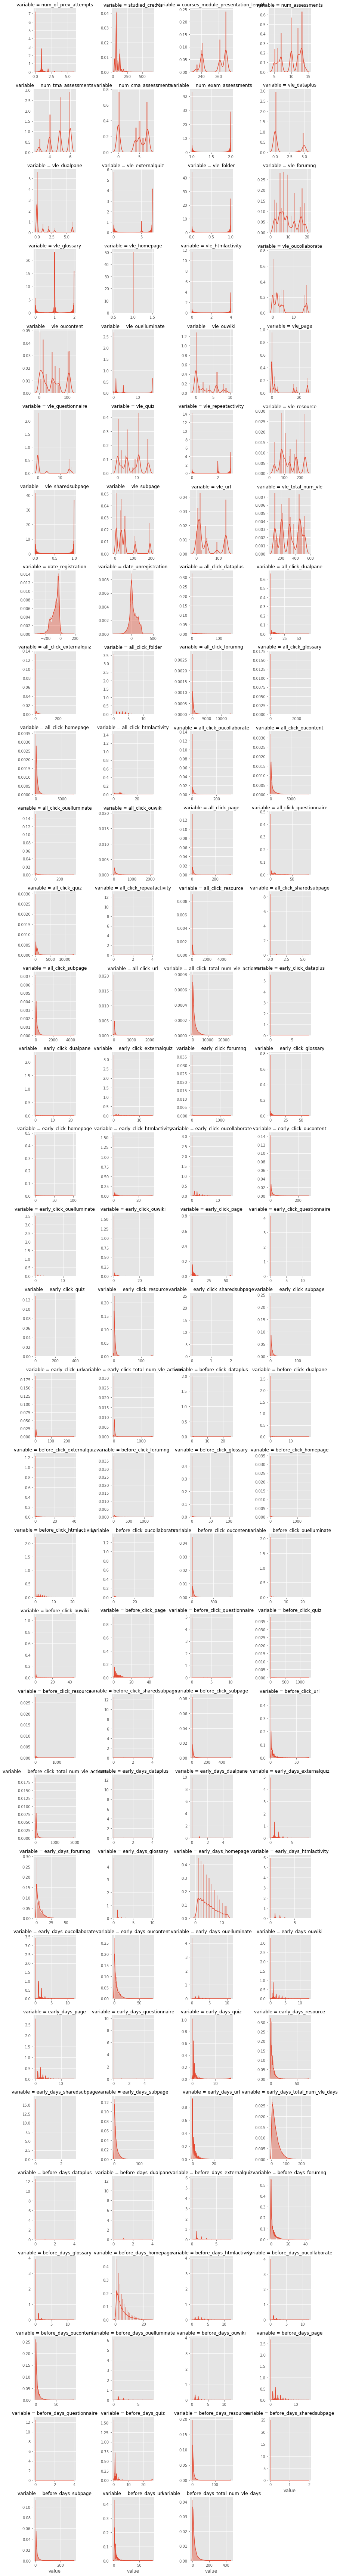

In [82]:
#create numeric plots
num = [f for f in df_eda.columns if df_eda.dtypes[f] != 'object']

nd = pd.melt(df_eda, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

* date_registraion
* date_unregistration
* Previous Attempts
* Studied Credits
* Num Assessments
* vle_total_num_vle (some num - maybe below and above 300)
* click_total_num_vle_actions (some num - maybe below and above 300)

* Date Registration

In [83]:
bin_labels_5 = ['lowest', 'low', 'mid', 'high', 'highest']
x = pd.qcut(df_eda['date_registration'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=bin_labels_5)

In [84]:
y = df_eda.final_result_edit.apply(lambda x: 1 if x =='Pass' else 0)

In [90]:
cross_tab = 1-pd.concat([x,y], axis=1).groupby('date_registration').mean()

In [91]:
cross_tab

,final_result_edit
date_registration,
lowest,0.579486
low,0.535550
mid,0.510500
high,0.500658
highest,0.509383


In [92]:
result_registration = pd.merge(x, cross_tab, how='left', on=['date_registration'])                                                

In [93]:
y_probas_registration = pd.merge(X_test, result_registration.final_result_edit, how = 'left', left_index = True, right_index = True)['final_result_edit']

In [94]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_registration.fillna(0))
auc(fpr, tpr)

0.5215778359811857

* Date Unregistration

In [97]:
bin_labels_5 = ['lowest', 'low', 'mid', 'high', 'highest']
x = pd.qcut(df_eda['date_unregistration'],
                              q=5,
                              labels=bin_labels_5)

In [98]:
x = x.cat.add_categories('registered')
x.fillna('registered', inplace =True) 


In [99]:
cross_tab =1- pd.concat([x,y], axis=1).groupby('date_unregistration').mean()

In [100]:
result_unregistration = pd.merge(x, cross_tab, how='left', on=['date_unregistration'])                                                


In [101]:
y_probas_unregistration = pd.merge(X_test, result_unregistration.final_result_edit, how = 'left', left_index = True, right_index = True)['final_result_edit']

In [102]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_unregistration)
auc(fpr, tpr)

0.7833217027215631

* Total VLE

In [105]:
bin_labels_5 = ['lowest', 'low', 'mid', 'high', 'highest']
x = pd.qcut(df_eda['vle_total_num_vle'],
                              q=5,
                              labels=bin_labels_5)

In [106]:
cross_tab = 1-pd.concat([x,y], axis=1).groupby('vle_total_num_vle').mean()

In [107]:
result_vle = pd.merge(x, cross_tab, how='left', on=['vle_total_num_vle'])                                                
y_probas_vle = pd.merge(X_test, result_vle.final_result_edit, how = 'left', left_index = True, right_index = True)['final_result_edit']

fpr, tpr, thresholds = roc_curve(y_test, y_probas_vle.fillna(0))
auc(fpr, tpr)

0.5272565048350115

* Total VLE Clicks

In [111]:
bin_labels_5 = ['lowest', 'low', 'mid', 'high', 'highest']
x = pd.qcut(df_eda['all_click_total_num_vle_actions'],
                              q=5,
                              labels=bin_labels_5)

In [115]:
cross_tab = 1-pd.concat([x,y], axis=1).groupby('all_click_total_num_vle_actions').mean()

In [116]:
result_vle_clicks = pd.merge(x, cross_tab, how='left', on=['all_click_total_num_vle_actions'])                                                
y_probas_vle_clicks = pd.merge(X_test, result_vle_clicks.final_result_edit, how = 'left', left_index = True, right_index = True)['final_result_edit']

fpr, tpr, thresholds = roc_curve(y_test, y_probas_vle_clicks.fillna(0))
auc(fpr, tpr)

0.6657306894082888

* Studied Credits

In [117]:
bin_labels_5 = ['low', 'mid', 'high']
x = pd.qcut(df_eda['studied_credits'],
                              q=3)


In [118]:
cross_tab = 1-pd.concat([x,y], axis=1).groupby('studied_credits').mean()

In [119]:
cross_tab

,final_result_edit
studied_credits,
"(29.999, 60.0]",0.482011
"(60.0, 90.0]",0.563184
"(90.0, 655.0]",0.623525


In [120]:
mask = (X_test['studied_credits'] <60)

In [121]:
# predicting Pass if studied credits below 60
y_predict = np.array(mask)

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

(0.4605473064179654, 0.4488935721812434, 0.09909281228192603)

In [122]:
result_studied_credits = pd.merge(x, cross_tab, how='left', on=['studied_credits'])                                                
y_probas_studied_credits = pd.merge(X_test, result_studied_credits.final_result_edit, how = 'left', left_index = True, right_index = True)['final_result_edit']

fpr, tpr, thresholds = roc_curve(y_test, y_probas_studied_credits.fillna(0))
auc(fpr, tpr)

0.5575766638571942

### Moving towards Refining Unregistration Info

In [123]:
df_eda.date_unregistration.value_counts()

 12.0     788
 0.0      419
 27.0     170
-1.0      147
-2.0       99
         ... 
 232.0      1
-197.0      1
-27.0       1
-192.0      1
-157.0      1
Name: date_unregistration, Length: 416, dtype: int64

In [124]:
x = pd.qcut(df_eda['date_unregistration'],
                              q=10)

In [125]:
x.value_counts()

(0.0, 12.0]          1349
(-38.0, -8.0]        1087
(27.0, 55.0]         1021
(-365.001, -38.0]    1011
(93.0, 130.0]        1009
(55.0, 93.0]         1009
(130.0, 170.0]       1002
(-8.0, 0.0]           999
(170.0, 444.0]        991
(12.0, 27.0]          594
Name: date_unregistration, dtype: int64

In [126]:
x.value_counts().sum()

10072

In [127]:
len(df_eda)

32593

In [128]:
x.value_counts().sum()/len(df_eda)

0.30902340993464855

* 30% of Students Withdraw


* 30% of withdrawals happen before class starts -> Remove those students
* Addtl 13% of withdrawals occur within first 12 days of class
* Should I remove all these students above

#### Running model taking out withdrawn students to see

In [ ]:
df_no_w = result[result.final_result != 'Withdrawn']

In [ ]:
df_no_w = df_no_w.drop(['final_result', 'code_module', 'code_presentation', 'id_student', 'courses_date_time'], axis = 1)

In [ ]:
df_no_w = pd.get_dummies(df_no_w)

In [ ]:
df_no_w = df_no_w.drop(['final_result_edit_Fail'],axis = 1)
df_no_w = df_no_w.drop(['date_unregistration'],axis = 1)
y_no_w = df_no_w.pop('final_result_edit_Pass')
X_no_w = df_no_w


In [ ]:

X_train_no_w, X_test_no_w, y_train_no_w, y_test_no_w = train_test_split(X_no_w, y_no_w, shuffle = True, test_size = 0.25, random_state = 42)

In [ ]:
X_train_no_w = X_train_no_w.fillna(0)
X_test_no_w = X_test_no_w.fillna(0)

initial_trees = int(np.sqrt(len(X_train_no_w.columns)))
